
# Entropy from ancestry coefficients (q) and genotype probabilities (gprob)  

Does everything to run entropy and creates slurm files to submit

Goal is 4 chains k=2-X (you decide)

**Create conda env just for entropy**  
`conda create -n entropy`  
`conda activate entropy`  
`conda install popgen-entropy`  


## SUBSET: 

#### This is a subset of individuals decided by ERNA_012 rarifies varieties and populations 

In [97]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

In [98]:
root = "/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/"

In [99]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [100]:
!mkdir entropy_sub

mkdir: cannot create directory ‘entropy_sub’: File exists


In [101]:
ent_dir =os.path.join(root,'entropy_sub')
assert ent_dir

In [102]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub


#### Subset vcf file by Pop_ID_sub.csv

In [103]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [104]:
%%R
require(readr)
require(MASS)
require(LEA)
require(tidyverse)
require(ggsci)

source('/data/gpfs/assoc/denovo/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub')

Pop_ID_sub <- read.csv('Pop_ID_sub.csv')
print(nrow(Pop_ID_sub))
print(table(as.character(Pop_ID_sub$Variety)))

[1] 160

   arenaria   bigelovii  graveolens   hololueca      iridis      juncea 
          5           8          11          24           6          11 
latisquamea  mohavensis        nana      nitida   oreophila salicifolia 
          6           5           5           6          18          22 
   speciosa   turbinata 
         22          11 


In [105]:
%%R 
# write file with individuals to keep 
keep_sub <- data.frame(INDV=as.character(Pop_ID_sub$All))
write.table(keep_sub,'keep_sub.txt',row.names=FALSE,quote=FALSE)

In [106]:
!cp ../SNPcall/filtering/good_snps.recode.vcf.gz .

#### Filter vcf to keep only subset individuals AND same MAF (0.02) / missing data (0.7)

In [107]:
!vcftools --gzvcf 'good_snps.recode.vcf.gz' \
--max-missing 0.7 \
--maf 0.02 \
--recode \
--recode-INFO-all \
--keep 'keep_sub.txt' \
--out 'ERNA_sub'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf good_snps.recode.vcf.gz
	--keep keep_sub.txt
	--recode-INFO-all
	--maf 0.02
	--max-missing 0.7
	--out ERNA_sub
	--recode

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 160 out of 586 Individuals
Outputting VCF file...
After filtering, kept 18592 out of a possible 22917 Sites
Run Time = 11.00 seconds


In [108]:
vcf_sub = 'ERNA_sub.recode.vcf'
vcf_sub_gz = vcf_sub + ".gz"
!bgzip -c $vcf_sub > $vcf_sub_gz
!tabix $vcf_sub_gz

In [109]:
!rm 'ERNA_sub.log'
!rm 'ERNA_sub.recode.vcf.gz.tbi'

In [110]:
!vcftools --gzvcf 'ERNA_sub.recode.vcf.gz' \
--012 \
--out 'ERNA_sub.recode.vcf.gz'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ERNA_sub.recode.vcf.gz
	--012
	--out ERNA_sub.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 160 out of 160 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 18592 out of a possible 18592 Sites
Run Time = 2.00 seconds


### Create mgpl & pntest files with associated dir 

#### copy good_snps.recode.vcf.gz from filtering

In [111]:
vcf = 'ERNA_sub.recode.vcf'
vcf

'ERNA_sub.recode.vcf'

In [112]:
perl_mpgl = '/data/gpfs/assoc/denovo/src/perl_scripts/vcf2mpgl_universal.pl'
perl_mean = '/data/gpfs/assoc/denovo/src/perl_scripts/gl2genest_universal.pl'

In [113]:
!perl $perl_mpgl $vcf

Number of loci: 18592; number of individuals 160


In [114]:
mpgl = 'ERNA_sub.recode.mpgl'

In [115]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [116]:
%%R
g <- read.table("pntest_mean_ERNA_sub.recode.txt", header=F)
dim(g)

[1] 18592   160


In [117]:
%%R

#create Pop_ID file 

indv<-read.table("ERNA_sub.recode.vcf.gz.012.indv",sep="\t")

Pop_ID <- data.frame(Pop=rep(NA,times=nrow(indv)),
                     ID=NA,
                     All=NA)
for (i in 1:nrow(indv)){
    name_list <-unlist(strsplit(as.character(indv$V1[i]),"_"))
    Pop_ID$Pop[i] <- name_list[2]
    Pop_ID$ID[i] <- as.integer(name_list[3])
    Pop_ID$All[i] <- as.character(indv$V1[i])
}
#print(head(Pop_ID))
#print(length(unique(Pop_ID$Pop)))

### merge with Pop_ID_sub
Pop_ID_sub <- left_join(Pop_ID,Pop_ID_sub[,1:10])

Joining, by = c("Pop", "ID", "All")


In [118]:
%%R
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.07233 0.05319 0.04972 0.03875 0.02333 


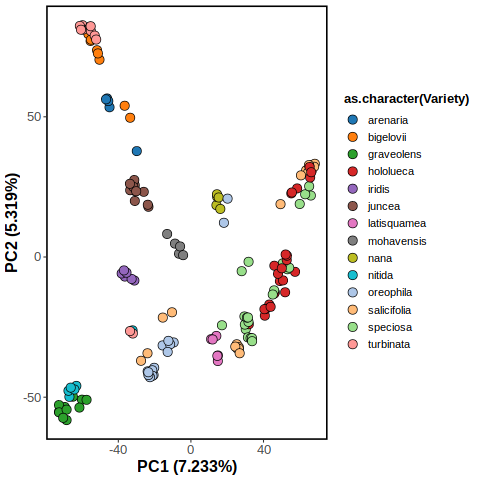

In [120]:
%%R

### check pntest_mean PCA looks okay
pca_df <- cbind(pca_df[,1:10],Pop_ID_sub)


ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=as.character(Variety))) +
  geom_point(pch=21,colour='black',size = 4) + 
  xlab(paste("PC",1," (",0.07233*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.05319*100,"%)",sep="")) +
  scale_fill_d3(palette='category20') +
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",
                                  face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())


In [121]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [122]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [123]:
!head entropy_header.txt

160 18592                                                                                                                                                               
AR_2 AR_3 AR_4 AR_5 AR_6 AS_18 AS_20 AS_23 AS_24 AS_28 AS_30 BO_1 BO_2 BO_3 BO_4 BO_5 BO_6 CH_1 CH_2 CH_3 CH_4 CH_6 CH_7 CI_1 CI_2 CI_3 CI_4 CI_5 CL_1 CL_2 CL_3 CL_4 CL_5 CL_6 CN_1 CN_2 CN_4 CN_5 CN_6 CO_1 CO_2 CO_3 CO_4 CO_5 CT_1 CT_2 CT_3 CT_4 CT_5 CT_6 DH_16 DH_17 DH_19 DH_20 DH_23 DH_28 EW_1 EW_2 EW_4 EW_5 EW_6 EW_8 IO_1 IO_2 IO_3 IO_4 IO_5 JO_2 JO_3 JO_4 JO_5 JO_6 JT_1 JT_2 JT_3 JT_4 JT_5 JT_6 LA_1 LA_2 LA_3 LA_4 LA_5 LA_6 LO_1 LO_2 LO_3 LO_4 LO_5 LT_4 LT_5 LT_6 NH_2 NH_3 NH_4 NH_5 NH_6 NI_1 NI_2 NI_3 NI_4 NI_5 NI_6 NT_1 NT_2 NT_3 NT_4 NT_5 OT_1 OT_2 OT_3 OT_4 PW_15 PW_1 PW_3 PW_4 PW_5 PW_9 RL_1 RL_2 RL_3 RL_4 RL_5 RL_6 RS_1 RS_2 RS_4 RS_5 RS_6 RS_7 RT_1 RT_2 SJ_10 SJ_12 SJ_1 SJ_2 SJ_8 SJ_9 SS_10 SS_12 SS_15 SS_3 SS_5 SS_9 TO_1 TO_2 TO_3 TO_4 TO_5 TO_6 UT_1 UT_2 UT_3 UT_4 UT_5 VI_1 VI_2 VI_3 VI_4 VI_5


In [124]:
!cat entropy_header.txt ERNA_sub.recode.mpgl > entropy.mpgl

In [125]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub


In [126]:
!mkdir shdir

In [127]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '14-00:00:00' #time limit 4
cpus = 4 #to prevent hammering one node
mem_cpu = 8000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7,8,9]
chains = 4

**Note:** Random seed needs to be created for each chain. Most programs use the clock as the seed, which is typically fine but since the clock on the HPC only goes to minutes and we are running everything at the same time, all the seeds are the same. Giving you the same exact seed. 

In [128]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [129]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [130]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_entropy_k4_c3.sh',

In [131]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [132]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [45]:
np.set_printoptions(precision=8) # increases float print option
#pd.set_option("precision", 8)

In [133]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub


In [134]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
#hdf5_files

In [135]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [136]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [137]:
dic_files = !find . -name 'DIC*'
len(dic_files),dic_files[0]

(32, './DIC_k2_c4.txt')

In [138]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4936449.58
Effective number of parameters: 2651068.15
Model DIC: 7587517.73


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4189320.77
Effective number of parameters: 3304980.34
Model DIC: 7494301.11


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4936629.28
Effective number of parameters: 2513141.99
Model DIC: 7449771.27


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4233513.37
Effective number of parameters: 3400545.26
Model DIC: 7634058.64


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 4681686.03
Effective number of parameters: 2509182.02
Model DIC: 7190868.05


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: samples = 5000, c

In [139]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,7587517.73,4
1,7,7494301.11,2
2,2,7449771.27,1
3,6,7634058.64,1
4,3,7190868.05,2


In [140]:
dic_df.to_csv('dic_list.csv')

In [141]:
dic_sum = dic_df.groupby('k').describe().DIC

In [142]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
4,4.0,7.085593e+06,94034.848196,6969020.98,7.029440e+06,7105454.920,7.161608e+06,7162441.42
5,4.0,7.188168e+06,102321.815874,7089285.70,7.113788e+06,7175066.420,7.249447e+06,7313254.93
3,4.0,7.191336e+06,114590.814620,7053240.72,7.153857e+06,7189131.905,7.226611e+06,7333839.03
6,4.0,7.472509e+06,118425.170690,7357897.21,7.404146e+06,7449040.715,7.517404e+06,7634058.64
2,4.0,7.526406e+06,84010.707611,7449771.27,7.456332e+06,7523018.640,7.593092e+06,7609816.44
7,4.0,7.664665e+06,241956.683719,7477001.80,7.489976e+06,7592099.490,7.766788e+06,7997457.85
8,4.0,8.468876e+06,170188.217244,8351650.59,8.384311e+06,8401102.530,8.485667e+06,8721648.79
9,4.0,8.628777e+06,441585.135264,8193876.91,8.363576e+06,8550594.055,8.815795e+06,9220041.65


In [143]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [144]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

#!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

#!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt

#!$estpost *k9*.hdf5 -p q -s 0 -o q9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 160, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 160, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 160, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 160, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 160, populations = 6, samples = 5000, chains = 4


In [145]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

#!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

#!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

#!$estpost *k9*.hdf5 -p q -s 4 -o MCMC_k9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 160, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 160, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 160, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 160, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 160, populations = 6, samples = 5000, chains = 4


### make slurm script to make gprob file

    use all k and chains to make gprob

In [58]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub


In [146]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6]

In [147]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [148]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [149]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub/shdir/run_gprob_k6.sh']

In [150]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [151]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

select only the ks you want. Will not work on ~7 ks with all the chains. It dies. 

Run 2,3,4,5,6 together

In [152]:
hdf5_files = []
num_k = [2,3,4,5,6]
num_c = 4
for k in num_k:
    for c in range(1,num_c+1):
        f = '../entropy_k' + str(k) + '_c' + str(c) + '.hdf5'
        hdf5_files.append(f)
hdf5_files

['../entropy_k2_c1.hdf5',
 '../entropy_k2_c2.hdf5',
 '../entropy_k2_c3.hdf5',
 '../entropy_k2_c4.hdf5',
 '../entropy_k3_c1.hdf5',
 '../entropy_k3_c2.hdf5',
 '../entropy_k3_c3.hdf5',
 '../entropy_k3_c4.hdf5',
 '../entropy_k4_c1.hdf5',
 '../entropy_k4_c2.hdf5',
 '../entropy_k4_c3.hdf5',
 '../entropy_k4_c4.hdf5',
 '../entropy_k5_c1.hdf5',
 '../entropy_k5_c2.hdf5',
 '../entropy_k5_c3.hdf5',
 '../entropy_k5_c4.hdf5',
 '../entropy_k6_c1.hdf5',
 '../entropy_k6_c2.hdf5',
 '../entropy_k6_c3.hdf5',
 '../entropy_k6_c4.hdf5']

In [153]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c1.hdf5 ../entropy_k2_c2.hdf5 ../entropy_k2_c3.hdf5 ../entropy_k2_c4.hdf5 ../entropy_k3_c1.hdf5 ../entropy_k3_c2.hdf5 ../entropy_k3_c3.hdf5 ../entropy_k3_c4.hdf5 ../entropy_k4_c1.hdf5 ../entropy_k4_c2.hdf5 ../entropy_k4_c3.hdf5 ../entropy_k4_c4.hdf5 ../entropy_k5_c1.hdf5 ../entropy_k5_c2.hdf5 ../entropy_k5_c3.hdf5 ../entropy_k5_c4.hdf5 ../entropy_k6_c1.hdf5 ../entropy_k6_c2.hdf5 ../entropy_k6_c3.hdf5 ../entropy_k6_c4.hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [154]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [155]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [156]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 

    cd /data/gpfs/assoc/denovo/PHHA/entropy
    source activate entropy
    sbatch run_gprob.sh